In [ ]:
import numpy as np
from collections import deque

class Datum:
    def __init__(self, idx, v = 0., apdict = None):
        self.idx = idx
        self.v = v
        self.apdict = apdict if apdict != None else {}

def D(di, dj):
    return np.sqrt(np.sum(np.array([np.power(i, 2) for i in (di - dj).flatten()])))

In [12]:
# initialize input space
M = np.random.randint(0, 100, (1000, 1, 2))
n = M.shape[0]

# initialize objects
data = []
for idx in range(n):
  data.append(Datum(idx))
# step 1-1: all pairs distances
for idx in range(n):
  for jdx in range(n):
    # if idx == jdx:
    #   continue
    dist = D(M[idx], M[jdx])
    data[idx].apdict[jdx] = dist
# step 1-2: V values for objects j

# precalculate denominators
denominators = []
for di in data:
  isum = 0.
  for i in di.apdict:
    isum += di.apdict[i]
  denominators.append(isum)

# compute v values
for j, dj in enumerate(data):
  big_sum = 0.
  for idx in dj.apdict:
    denominator = denominators[idx]
    numerator = dj.apdict[idx]
    big_sum += np.divide(numerator, denominator)
  data[j].v = big_sum
# step 1-3: sort by v value and choose k medioids
sortkey = lambda d: d.v
sorted_data = sorted(data, key=sortkey)
k = 4
medioid_idx = set([i.idx for i in sorted_data[:k]])
print(medioid_idx)

In [16]:
# step 1-4: Obtain the initial cluster result by assigning each object to the nearest medoid.
def assign_clusters(data, mlist):
  """
  assign the data to clusters
  """
  clusters = [[] for _ in mlist]
  for idx in range(n):
    di = data[idx]
    min_dist = float('inf')
    mindex = None
    for i, midx in enumerate(mlist):
      if midx == idx:
        mindex = i
        break
      if di.apdict[midx] < min_dist:
        min_dist = di.apdict[midx]
        mindex = i
    
    clusters[mindex].append(idx)
  return clusters

# mlist = list(medioid_idx)
# clusters = assign_clusters(data, mlist)

In [17]:
# step 1-5
def calculate_sum(data, clusters, mlist):
  total_sum = 0.
  for i, midx in enumerate(mlist):
    cluster = clusters[i]
    for idx in cluster:
      total_sum += data[idx].apdict[midx]
  return total_sum

In [19]:
def update_medioids(data, clusters, mlist):
  new_mlist = []
  for i,midx in enumerate(mlist):
    cluster = clusters[i]
    min_dist = float('inf')
    mindex = None
    for idx in cluster:
      cdist = 0.
      for sidx in cluster:
        cdist += data[idx].apdict[sidx]
      if cdist < min_dist:
        min_dist = cdist
        mindex = idx
    new_mlist.append(mindex)
  
  return new_mlist

# mlist = update_medioids(data, clusters ,mlist)

In [22]:
def kmedioids(M, data, k=5, max_iter=100):
  sortkey = lambda d: d.v
  sorted_data = sorted(data, key=sortkey)
  k = 5
  medioid_idx = set([i.idx for i in sorted_data[:k]])
  mlist = list(medioid_idx)
  n = M.shape[0]
  total_sum = float('inf')
  for _ in range(max_iter):
    clusters = assign_clusters(data, mlist)
    mlist = update_medioids(data, clusters ,mlist)
    new_sum = calculate_sum(data, clusters, mlist)
    if new_sum == total_sum:
      break
    total_sum = new_sum
  return clusters, mlist
    



In [23]:
clusters, mlist = kmedioids(M, data, k, 20)
medioids = np.array([M[idx] for idx in mlist])
for i in range(k):
  clusters[i] = np.stack([M[j] for j in clusters[i]])
  print(clusters[i].shape)


(19, 1, 2)
(21, 1, 2)
(20, 1, 2)
(16, 1, 2)


(19, 2)
(21, 2)
(20, 2)
(16, 2)


AttributeError: 'list' object has no attribute 'reshape'

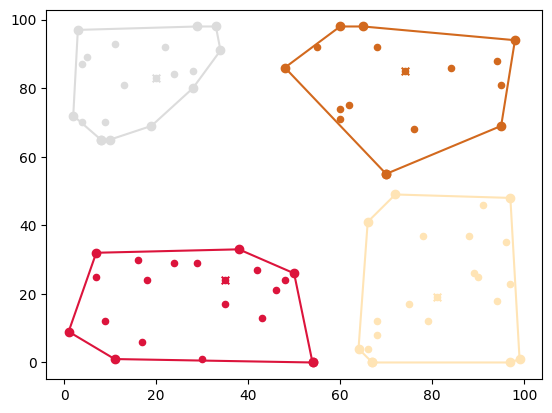

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def graham_scan_convex_hull(points):
    def cross_product(p, q, r):
        return (q[0] - p[0]) * (r[1] - p[1]) - (r[0] - p[0]) * (q[1] - p[1])

    def polar_angle(p, q):
        return np.arctan2(q[1] - p[1], q[0] - p[0])

    # Find the point with the lowest y-coordinate (and leftmost if tied)
    start_point = min(points, key=lambda p: (p[1], p[0]))

    # Sort the points based on polar angles with respect to the start point
    sorted_points = sorted(points, key=lambda p: (polar_angle(start_point, p), -p[1], p[0]))

    # Initialize the convex hull with the first three sorted points
    convex_hull = [sorted_points[0], sorted_points[1], sorted_points[2]]

    # Iterate through the sorted points and construct the convex hull
    for point in sorted_points[3:]:
        while len(convex_hull) >= 2 and cross_product(convex_hull[-2], convex_hull[-1], point) <= 0:
            convex_hull.pop()
        convex_hull.append(point)

    return convex_hull

# Reshape the array to (100, 2) for plotting
colors = list(set(mcolors.CSS4_COLORS))[::4]
# print(colors)
reshaped_centers = medioids.reshape(-1, 2)
cx_coords = reshaped_centers[:, 0]
cy_coords = reshaped_centers[:, 1]

for i,m in enumerate(clusters):

  reshaped_data = m.reshape(-1, 2)
  print(reshaped_data.shape)
    # Compute the convex hull using Graham Scan
  convex_hull = graham_scan_convex_hull(reshaped_data)
  convex_hull.append(convex_hull[0])


  # Convert the convex hull points to a numpy array for visualization
  convex_hull_array = np.array(convex_hull)
  

  # Plot the original points and the convex hull
  # plt.scatter(reshaped_data[:, 0], reshaped_data[:, 1], c='blue', label='Points')
  plt.plot(convex_hull_array[:, 0], convex_hull_array[:, 1], c=colors[i], marker='o', label='Convex Hull')

  x_coords = reshaped_data[:, 0]
  y_coords = reshaped_data[:, 1]
  plt.scatter(x_coords, y_coords, marker="o", color=colors[i], s=20)
  plt.scatter(cx_coords[i], cy_coords[i], marker="x", color=colors[i], s=30)

# Add labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatter Plot of Data Points")

# Display the plot
plt.show()

